In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [40]:
transform = transforms.ToTensor() #To convert all pixel values to tensor
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size = 64, shuffle = True ) #Taking 64 image-label pairs at a time

In [41]:
dataiter = iter(data_loader) #Creating an iterating object for the data_loader
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## Using Simple Linear Layers for an Autoencoder

In [49]:
#Creating class for Autoencoder
#MNIST dataset has all images of size (28x28) = 784, N is the number of images in the batch, in this case N=64
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 128), # (N,784) --> (N,128)
                                     nn.ReLU(),
                                     nn.Linear(128,64),
                                     nn.ReLU(),
                                     nn.Linear(64,12),
                                     nn.ReLU(),
                                     nn.Linear(12,3) # (N,12) --> (N,3)
                                     )

        self.decoder = nn.Sequential(nn.Linear(3, 12),
                                     nn.ReLU(),
                                     nn.Linear(12,64),
                                     nn.ReLU(),
                                     nn.Linear(64,128),
                                     nn.ReLU(),
                                     nn.Linear(128,28*28), # (N,3) --> (N,784)
                                     nn.Sigmoid() #We need an activation layer in the end as we know that the final values must lie between 0 and 1
                                     )
        # if transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))]), then the min and the max values would be -1 and 1 respectively.
        # In that case, the final activation of the decoder should have been nn.Tanh()

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded #,encoded # If only decoded is returned then we get the reconstructed image

In [50]:
model = Autoencoder() #Creating an instance
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3, weight_decay = 1e-5)

In [51]:
##Training Loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28) #We do this because we want the shape of the batch to be (N,784) to be given as input to our model
        reconstructed_img = model(img)
        loss = criterion(reconstructed_img, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch,img, reconstructed_img))



Epoch: 1, Loss: 0.0472
Epoch: 2, Loss: 0.0387
Epoch: 3, Loss: 0.0392
Epoch: 4, Loss: 0.0348
Epoch: 5, Loss: 0.0399
Epoch: 6, Loss: 0.0339
Epoch: 7, Loss: 0.0319
Epoch: 8, Loss: 0.0332
Epoch: 9, Loss: 0.0380
Epoch: 10, Loss: 0.0376


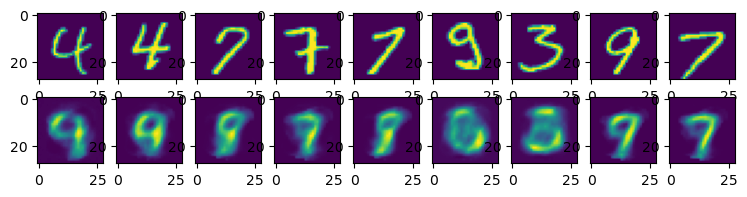

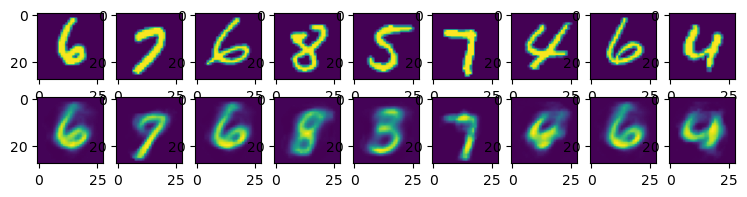

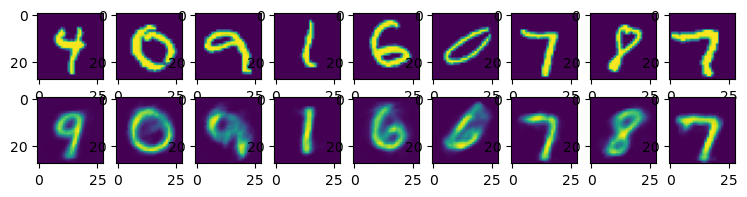

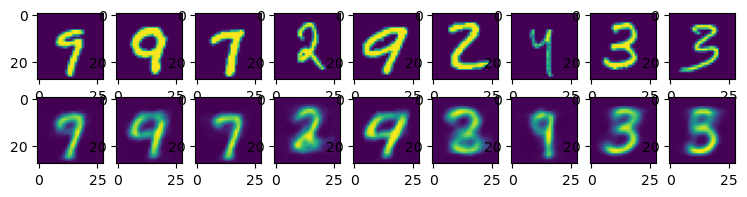

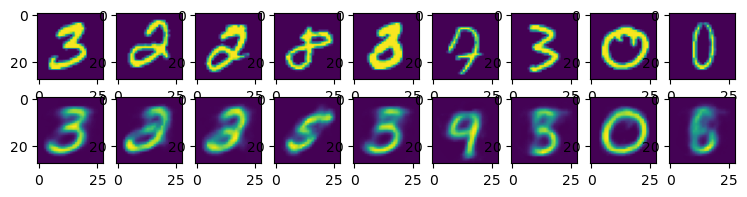

In [53]:
#Plotting the first 9 ground truth and reconstructed images for every 2 epochs
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1) # 2 rows, 9 columns,image number accordinf to iteration
        item = item.reshape(-1,28,28) # Need to reshape the images to (1,28,28) from (1,784)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1,28,28)
        plt.imshow(item[0])

## Using CNN layers for an Autoencoder to see the change in performance compared to the former

In [54]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape of image: (N, 1, 28, 28)
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, 3, stride = 2, padding = 1), #   1-D input, 16- (3x3) convolutional filters, output size = (N, 16, 14, 14)
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 3, stride = 2, padding = 1), # output size = (N, 32, 7, 7)
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 7) # output size = (N, 64, 1, 1)
                                     )
        #Size of latent output = (N, 64, 1, 1)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 7), # (N, 32, 7, 7)
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding= 1),
                                     # (N, 16, 13, 13), but we need (14,14), so apply output_padding= 1
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding= 1), #(N, 1, 27, 27) --> (N, 1, 28, 28) through output_padding
                                     nn.Sigmoid() #We need an activation layer in the end as we know that the final values must lie between 0 and 1
                                     )
        # if transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))]), then the min and the max values would be -1 and 1 respectively.
        # In that case, the final activation of the decoder should have been nn.Tanh()

        # In case if nn.MaxPool2d is used inside the encoder, then nn.MaxUnpool2d should be employed in the decoder

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded #,encoded # If only decoded is

In [55]:
model = Autoencoder_CNN() #Creating an instance
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3, weight_decay = 1e-5)

In [56]:
##Training Loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        reconstructed_img = model(img)
        loss = criterion(reconstructed_img, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch,img, reconstructed_img))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 1, Loss: 0.0108
Epoch: 2, Loss: 0.0052
Epoch: 3, Loss: 0.0047
Epoch: 4, Loss: 0.0039
Epoch: 5, Loss: 0.0029
Epoch: 6, Loss: 0.0029
Epoch: 7, Loss: 0.0025
Epoch: 8, Loss: 0.0028
Epoch: 9, Loss: 0.0029
Epoch: 10, Loss: 0.0031


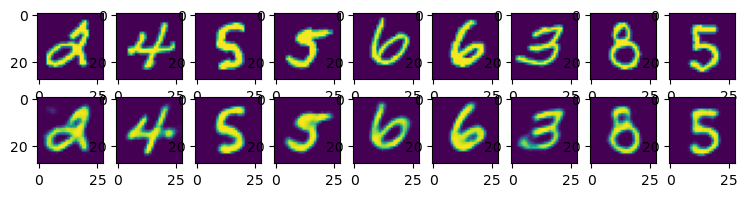

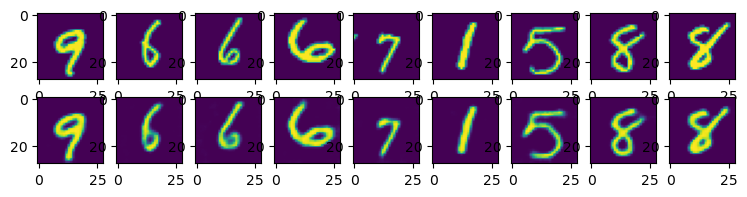

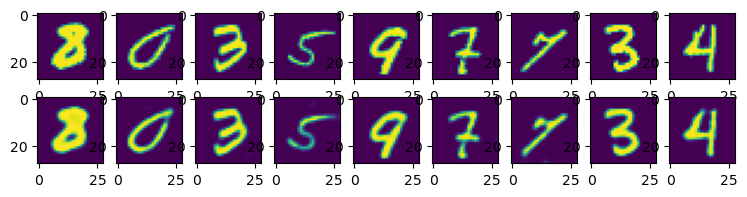

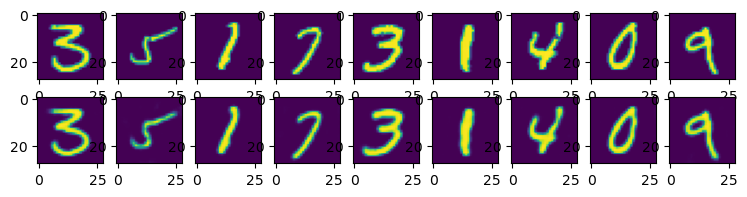

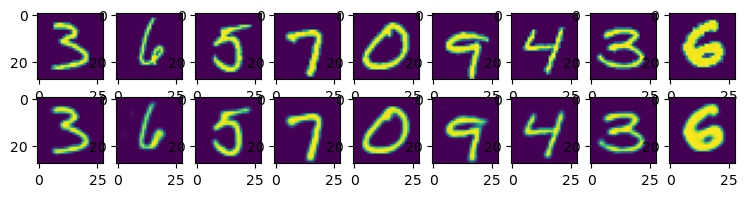

In [57]:
#Plotting the first 9 ground truth and reconstructed images for every 2 epochs
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i + 1)  # 2 rows, 9 columns,image number accordinf to iteration
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])